In [ ]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


## Load in reference data, normalized and cell type + sample corrected

In [26]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/cell2location/pt1/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map/N2_alpha200'

In [3]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File /home/ssobti/projects/farnaz_spatial/output_data/cell2location/pt1//reference_signatures/model.pt    
         already downloaded                                                                                        


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/101:   1%|▍                                         | 1/101 [00:01<03:04,  1.85s/it, v_num=1, elbo_train=1.11e+9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/101:   1%|▍                                         | 1/101 [00:01<03:05,  1.85s/it, v_num=1, elbo_train=1.11e+9]


In [4]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]



,luminal_epithelial_AV,luminal_epithelial_HS,mASPC1,mASPC2,mASPC3
0610005C13Rik,0.002101,0.017280,0.001715,0.000278,0.002418
0610009E02Rik,0.035571,0.222412,0.040235,0.022178,0.042449
0610009O20Rik,0.173939,0.624237,0.054152,0.048218,0.088596
0610010F05Rik,0.239057,0.988754,0.184802,0.265122,0.262344
0610012G03Rik,0.017029,0.157076,0.000625,0.000472,0.012359


In [5]:
inf_aver

,luminal_epithelial_AV,luminal_epithelial_HS,mASPC1,mASPC2,mASPC3,mASPC4,mASPC5,mASPC6,mAd1,mAd2,...,mTcell1,mTcell2,mTcell3,male_epithelial_1,male_epithelial_2,male_epithelial_3,mammary_fibroblast,mcDC1,mcDC2,myoepithelial
0610005C13Rik,0.002101,0.017280,0.001715,0.000278,0.002418,0.001220,0.001192,0.002002,0.051938,0.045130,...,0.001838,0.008184,0.005609,0.678894,0.076228,0.016342,0.014393,0.007922,0.003072,0.005295
0610009E02Rik,0.035571,0.222412,0.040235,0.022178,0.042449,0.043170,0.039565,0.059661,0.073922,0.097143,...,0.005407,0.007424,0.006665,0.057552,0.250455,0.019509,0.021445,0.008947,0.005602,0.016682
0610009O20Rik,0.173939,0.624237,0.054152,0.048218,0.088596,0.076151,0.058535,0.093397,0.115412,0.143340,...,0.021278,0.026251,0.035662,0.083812,0.118545,0.122982,0.024094,0.047134,0.015934,0.130075
0610010F05Rik,0.239057,0.988754,0.184802,0.265122,0.262344,0.240568,0.218179,0.264357,0.946780,1.252283,...,0.058058,0.050420,0.062929,0.168822,0.838138,0.097069,0.297802,0.096627,0.075664,0.172116
0610012G03Rik,0.017029,0.157076,0.000625,0.000472,0.012359,0.002012,0.000380,0.003835,0.097315,0.135716,...,0.002552,0.007868,0.011688,0.007658,0.008856,0.005001,0.034807,0.007132,0.003649,0.006253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wfdc10,0.863819,0.922484,0.594232,0.452393,0.987357,0.800057,0.618622,0.871841,0.435117,1.002545,...,0.976407,0.987112,0.944092,0.890320,1.079412,0.953721,0.929562,1.086247,0.971326,0.991041
Gm29099,0.739073,0.962503,0.664255,0.481389,0.848539,0.913897,0.734573,0.955015,0.385024,0.759303,...,0.899140,0.917563,1.073098,0.877399,0.928394,0.980034,1.071686,0.907765,0.928863,0.885193
Prm2,0.615280,0.748792,0.507481,0.461795,0.610804,0.798151,0.560407,0.812318,0.334053,0.641609,...,0.836624,1.049702,0.944804,0.834838,0.776262,0.976548,1.062867,0.923633,0.878110,0.861540
AC125444.1,0.432277,0.913377,0.653262,0.472652,0.622889,0.667338,0.463112,0.927433,0.292213,0.583968,...,0.863668,1.055517,0.934524,0.757079,0.793741,1.074086,0.971408,0.826751,0.957904,0.953200


In [6]:
adata_ref.uns['mod']['factor_names']

array(['luminal_epithelial_AV', 'luminal_epithelial_HS', 'mASPC1',
       'mASPC2', 'mASPC3', 'mASPC4', 'mASPC5', 'mASPC6', 'mAd1', 'mAd2',
       'mAd3', 'mAd4', 'mAd5', 'mAd6', 'mBcell', 'mDC3', 'mEndoA1',
       'mEndoA2', 'mEndoS1', 'mEndoS2', 'mEndoV', 'mLEC1', 'mLEC2',
       'mMac1', 'mMac2', 'mMac3', 'mMac4', 'mMac5', 'mMast', 'mMes1',
       'mMes2', 'mMes3', 'mMono1', 'mMono2', 'mNK', 'mNeu', 'mPeri',
       'mSMC', 'mTcell1', 'mTcell2', 'mTcell3', 'male_epithelial_1',
       'male_epithelial_2', 'male_epithelial_3', 'mammary_fibroblast',
       'mcDC1', 'mcDC2', 'myoepithelial'], dtype=object)

In [7]:
adata_ref.varm['means_per_cluster_mu_fg']

,means_per_cluster_mu_fg_luminal_epithelial_AV,means_per_cluster_mu_fg_luminal_epithelial_HS,means_per_cluster_mu_fg_mASPC1,means_per_cluster_mu_fg_mASPC2,means_per_cluster_mu_fg_mASPC3,means_per_cluster_mu_fg_mASPC4,means_per_cluster_mu_fg_mASPC5,means_per_cluster_mu_fg_mASPC6,means_per_cluster_mu_fg_mAd1,means_per_cluster_mu_fg_mAd2,...,means_per_cluster_mu_fg_mTcell1,means_per_cluster_mu_fg_mTcell2,means_per_cluster_mu_fg_mTcell3,means_per_cluster_mu_fg_male_epithelial_1,means_per_cluster_mu_fg_male_epithelial_2,means_per_cluster_mu_fg_male_epithelial_3,means_per_cluster_mu_fg_mammary_fibroblast,means_per_cluster_mu_fg_mcDC1,means_per_cluster_mu_fg_mcDC2,means_per_cluster_mu_fg_myoepithelial
0610005C13Rik,0.002101,0.017280,0.001715,0.000278,0.002418,0.001220,0.001192,0.002002,0.051938,0.045130,...,0.001838,0.008184,0.005609,0.678894,0.076228,0.016342,0.014393,0.007922,0.003072,0.005295
0610009E02Rik,0.035571,0.222412,0.040235,0.022178,0.042449,0.043170,0.039565,0.059661,0.073922,0.097143,...,0.005407,0.007424,0.006665,0.057552,0.250455,0.019509,0.021445,0.008947,0.005602,0.016682
0610009O20Rik,0.173939,0.624237,0.054152,0.048218,0.088596,0.076151,0.058535,0.093397,0.115412,0.143340,...,0.021278,0.026251,0.035662,0.083812,0.118545,0.122982,0.024094,0.047134,0.015934,0.130075
0610010F05Rik,0.239057,0.988754,0.184802,0.265122,0.262344,0.240568,0.218179,0.264357,0.946780,1.252283,...,0.058058,0.050420,0.062929,0.168822,0.838138,0.097069,0.297802,0.096627,0.075664,0.172116
0610012G03Rik,0.017029,0.157076,0.000625,0.000472,0.012359,0.002012,0.000380,0.003835,0.097315,0.135716,...,0.002552,0.007868,0.011688,0.007658,0.008856,0.005001,0.034807,0.007132,0.003649,0.006253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wfdc10,0.863819,0.922484,0.594232,0.452393,0.987357,0.800057,0.618622,0.871841,0.435117,1.002545,...,0.976407,0.987112,0.944092,0.890320,1.079412,0.953721,0.929562,1.086247,0.971326,0.991041
Gm29099,0.739073,0.962503,0.664255,0.481389,0.848539,0.913897,0.734573,0.955015,0.385024,0.759303,...,0.899140,0.917563,1.073098,0.877399,0.928394,0.980034,1.071686,0.907765,0.928863,0.885193
Prm2,0.615280,0.748792,0.507481,0.461795,0.610804,0.798151,0.560407,0.812318,0.334053,0.641609,...,0.836624,1.049702,0.944804,0.834838,0.776262,0.976548,1.062867,0.923633,0.878110,0.861540
AC125444.1,0.432277,0.913377,0.653262,0.472652,0.622889,0.667338,0.463112,0.927433,0.292213,0.583968,...,0.863668,1.055517,0.934524,0.757079,0.793741,1.074086,0.971408,0.826751,0.957904,0.953200


## Loading Visium data

In [8]:
# Set paths to data and results used through the document:
sp_data_folder = '/home/ssobti/projects/farnaz_spatial/data/'

In [14]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs',
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'visium.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [15]:
adata_vis.uns

OverloadedDict, wrapping:
	{'spatial': {'count-A1': {'images': {'hires': array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       ...,

       [[1.        , 1.        , 1.      

In [8]:
adata_vis.var

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-count-A1,mean_counts-count-A1,log1p_mean_counts-count-A1,pct_dropout_by_counts-count-A1,total_counts-count-A1,log1p_total_counts-count-A1,...,log1p_mean_counts-count-C1,pct_dropout_by_counts-count-C1,total_counts-count-C1,log1p_total_counts-count-C1,n_cells_by_counts-count-D1,mean_counts-count-D1,log1p_mean_counts-count-D1,pct_dropout_by_counts-count-D1,total_counts-count-D1,log1p_total_counts-count-D1
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951,Gene Expression,mm10,Xkr4,False,8,0.002927,0.002923,99.707281,8.0,2.197225,...,0.001383,99.861592,4.0,1.609438,3,0.001212,0.001211,99.878837,3.0,1.386294
ENSMUSG00000025900,Gene Expression,mm10,Rp1,False,1,0.000366,0.000366,99.963410,1.0,0.693147,...,0.000692,99.930796,2.0,1.098612,1,0.000404,0.000404,99.959612,1.0,0.693147
ENSMUSG00000025902,Gene Expression,mm10,Sox17,False,585,0.252470,0.225117,78.594951,690.0,6.538140,...,0.238390,77.681661,778.0,6.658011,506,0.245961,0.219907,79.563813,609.0,6.413459
ENSMUSG00000025903,Gene Expression,mm10,Lypla1,False,2141,1.993414,1.096414,21.661178,5448.0,8.603188,...,0.441042,58.961938,1602.0,7.379632,1021,0.619952,0.482396,58.764136,1535.0,7.336937
ENSMUSG00000033813,Gene Expression,mm10,Tcea1,False,1660,1.022320,0.704245,39.260885,2794.0,7.935587,...,0.358714,65.882353,1247.0,7.129298,885,0.494750,0.401959,64.256866,1225.0,7.111512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000000103,Gene Expression,mm10,Zfy2,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000069036,Gene Expression,mm10,Sry,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSMUSG00000102053,Gene Expression,mm10,Gm4064,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000


In [9]:
adata_vis.obs

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac
spot_id,,,,,,,,,,,,,
count-A1_AAACAAGTATCTCCCA-1,1,50,102,count-A1,3976,8.288283,10597.0,9.268420,22.421440,29.470605,38.312730,52.420496,0.0
count-A1_AAACACCAATAACTGC-1,1,59,19,count-A1,4429,8.396155,14374.0,9.573246,24.356477,31.904828,41.136775,55.356894,0.0
count-A1_AAACAGCTTTCAGAAG-1,1,43,9,count-A1,1826,7.510431,3311.0,8.105308,23.165207,30.927212,41.014799,59.649653,0.0
count-A1_AAACAGGGTCTATATT-1,1,47,13,count-A1,2560,7.848153,5105.0,8.538172,22.683643,29.676787,38.393732,53.535749,0.0
count-A1_AAACAGTGTTCCTGGG-1,1,73,43,count-A1,4224,8.348775,13278.0,9.493939,28.212080,34.907366,43.063714,56.409098,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
count-D1_TTGTTAGCAAATTCGA-1,1,22,42,count-D1,3821,8.248529,8888.0,9.092570,19.723222,26.642664,34.867237,48.773627,0.0
count-D1_TTGTTCAGTGTGCTAC-1,1,24,64,count-D1,2552,7.845024,4844.0,8.485703,21.717589,28.488852,36.952931,52.085054,0.0
count-D1_TTGTTTCACATCCAGG-1,1,58,42,count-D1,730,6.594413,970.0,6.878326,24.948454,35.051546,45.360825,76.288660,0.0


In [16]:
adata_vis.var.set_index('SYMBOL', drop=False, inplace=True)
adata_vis.var.index.name = None

In [17]:
## average or get rid of non-unique gene symbols now that you've gotten rid of ENSEMBL IDs
print('total genes:' + str(len(adata_vis.var.index)))
print('unique genes:' + str(len(np.unique(adata_vis.var.index))))
print('duplicates to make unique:' + str(len(adata_vis.var.index)-len(np.unique(adata_vis.var.index))))


total genes:19465
unique genes:19454
duplicates to make unique:11


In [18]:
adata_vis.var_names_make_unique()

In [19]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [20]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")


## Cell2location spatial mapping

In [21]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=2,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 10486 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12121 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  count-A1  │          0          │
│                     │  count-B1  │          1          │
│                     │  count-C1  │          2          │
│                     │  count-D1  │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2/2: 100%|██████████████████████████████████████████████| 2/2 [00:08<00:00,  4.38s/it, v_num=1, elbo_train=2.05e+8]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 2/2: 100%|██████████████████████████████████████████████| 2/2 [00:08<00:00,  4.38s/it, v_num=1, elbo_train=2.05e+8]


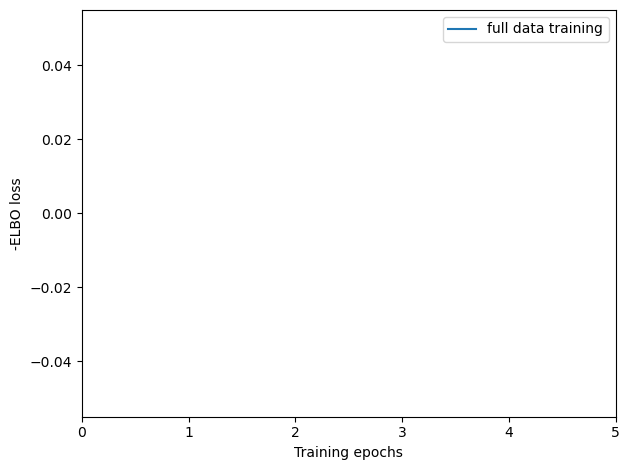

In [23]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [58]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|███████████████████████████████████████████████| 999/999 [07:25<00:00,  2.24it/s]


'/home/ssobti/projects/farnaz_spatial/output_data/cell2location/pt1//cell2location_map/sp.h5ad'

In [ ]:
mod.plot_QC()

In [ ]:
fig = mod.plot_spatial_QC_across_batches()

In [ ]:
fig